# Usage
1. Config your Google API key in the secrets
2. Run the first two cells to initialize the environment
3. Run either the third or fourth cell to initialize the personas and the evaluation criteria
4. Run the remaining cells to execute the evaluation and visualize the results

### Environment setup

In [ ]:
from copy import deepcopy
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Quantitative-Eval/master/requirements.txt

In [1]:
import os
import json
import operator
import re
from copy import deepcopy
from typing import TypedDict, Annotated, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.constants import END, START
from langgraph.graph import StateGraph
from tqdm import tqdm
from tenacity import retry, stop_after_attempt

# Load environment variables (GOOGLE_API_KEY should be set either in .env file or in the secrets)
try:
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
except ImportError:
    from dotenv import load_dotenv
    load_dotenv()
except KeyError:
    raise KeyError("Please set the GOOGLE_API_KEY in your secrets.")

# LLM config
# At here you can change the model, tweak its parameters, or even use different LLM provider
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature=0.7)

### Prompt setup
Use One of the following two cells to initialize the personas and the evaluation criteria.

In [ ]:
# Initialize personas and criteria by a llm
# To be implemented

In [2]:
# Initialize personas and criteria manually

# What to evaluate
EVALUATION_SUBJECT = "band"

# List of items to evaluate
ITEMS = [
    "The Beatles", "Led Zeppelin", "Pink Floyd", "Queen", "The Rolling Stones",
    "Metallica", "Megadeth", "Black Sabbath", "Iron Maiden", "Tool"
]

# Persona definitions
# Each persona has generates a call to the LLM, so please be aware of the rate limits of your LLM provider
# For Gemini, the rate limit is 10 calls per minute for 2.5 flash models and 5 calls per minute for 2.5 pro models.
PERSONAS = {
    "metalhead": "You're in your 30s, a lifelong metal fan. You value power, aggression, instrumental mastery, and complexity. You dismiss pop and overproduced music as shallow.",
    "popstar": "You're in your 20s, immersed in social media culture. You love global accessibility, emotional resonance, and catchy choruses. You believe great bands bring joy and unity.",
    "boomer": "You're in your 70s. You grew up during the golden age of rock and believe greatness is rooted in legacy, songwriting, and timeless appeal. Newer music feels synthetic to you.",
    "genz": "You're a teenager, online-native, and value diversity, identity, and innovation in music. You're drawn to bands that say something real or break genre rules.",
    "indie": "You're in your 30s, an art-school type who craves authenticity, emotion, and underground cool. You dislike commercial polish and love expressive weirdness.",
}

# Criteria for evaluation
CRITERIA = {
    "Musical Innovation": "Pioneering ideas, new sounds, genre blending.",
    "Cultural Impact": "Broader societal influence, pop culture penetration.",
    "Lyrical or Thematic Depth": "Narrative richness, philosophical weight, relatability.",
    "Technical Proficiency": "Musical complexity, virtuosity, performance execution.",
    "Live Performance Strength": "Energy, presence, crowd connection on stage.",
    "Legacy & Longevity": "Enduring influence across generations and artists."
}

# Instructions/background information for the personas
PERSONA_ROLE = "music critic"
INSTRUCTION = f"You have been asked to evaluate the greatness of {len(ITEMS)} historically significant bands across genres including rock, metal, pop, and progressive."


# Prompt template
def make_prompt(persona_description):
    return f"""You are a {PERSONA_ROLE} with the following worldview:

{persona_description}

{INSTRUCTION}

Evaluate each {EVALUATION_SUBJECT} based on the following {len(CRITERIA)} criteria, scoring from 1 (low) to 5 (high):

{"".join(f"{key}: {value}{chr(10)}" for key, value in CRITERIA.items())}
Here are the {EVALUATION_SUBJECT}s to evaluate:
{chr(10).join('- ' + item for item in ITEMS)}

Please respond ONLY in the following strict JSON format:

```json
{{
  "ratings": [
    {{
      "item": "the corresponding {EVALUATION_SUBJECT} name here"{"".join(f',{chr(10)}      "{criteria}": int' for criteria in CRITERIA)}
    }},
    // ...More {EVALUATION_SUBJECT} evaluations here
  ],
  "justification": "Your paragraph explaining the ratings here.",
  "ranking": ["{EVALUATION_SUBJECT}1", "{EVALUATION_SUBJECT}2", ..., "{EVALUATION_SUBJECT}{len(ITEMS)}"]
}}
```

- The ratings list must include all {len(ITEMS)} {EVALUATION_SUBJECT}s.
- The ranking list must be in your personal order (1st to {len(ITEMS)}th).
- Do not include any commentary outside the JSON block.
"""

print("Example prompt:")
print(make_prompt(list(PERSONAS.values())[0]))


Example prompt:
You are a music critic with the following worldview:

You're in your 30s, a lifelong metal fan. You value power, aggression, instrumental mastery, and complexity. You dismiss pop and overproduced music as shallow.

You have been asked to evaluate the greatness of 10 historically significant bands across genres including rock, metal, pop, and progressive.

Evaluate each band based on the following 6 criteria, scoring from 1 (low) to 5 (high):

Musical Innovation: Pioneering ideas, new sounds, genre blending.
Cultural Impact: Broader societal influence, pop culture penetration.
Lyrical or Thematic Depth: Narrative richness, philosophical weight, relatability.
Technical Proficiency: Musical complexity, virtuosity, performance execution.
Live Performance Strength: Energy, presence, crowd connection on stage.
Legacy & Longevity: Enduring influence across generations and artists.

Here are the bands to evaluate:
- The Beatles
- Led Zeppelin
- Pink Floyd
- Queen
- The Rolling 

### Generate the evaluation

In [3]:
print("Starting evaluation...")

# Clean LLM output
def clean_json_string(text: str) -> str:
    cleaned = re.sub(r"```(?:json)?", "", text)
    return cleaned.replace("```", "").strip()

# Parse JSON
def parse_json_response(response):
    response_cleaned = clean_json_string(response)
    data = json.loads(response_cleaned)
    ratings = data["ratings"]
    justification = data["justification"]
    ranking = data["ranking"]

    ranking_column = []
    for i, item in enumerate(ranking):
        ranking_column += [{"item": item, "rank": i + 1}]

    df = pd.DataFrame(ratings)

    df = pd.merge(df, pd.DataFrame(ranking_column), on="item", how="left")
    df.columns = [EVALUATION_SUBJECT] + list(CRITERIA.keys()) + ["Rank"]
    return df, justification

# Get llm response
@retry(stop=stop_after_attempt(3))
async def get_llm_response(prompt):
    response = await llm.ainvoke(prompt)
    return parse_json_response(response.content)

# State definition
class Vote(TypedDict):
    df: pd.DataFrame
    justification: str
    persona: str

class State(TypedDict):
    votes: Annotated[List[Vote], operator.add]

# Initialize progress bar
try:
    pbar.close()
except NameError:
    pass

pbar = tqdm(f"Evaluating {EVALUATION_SUBJECT}s with personas", total=len(PERSONAS), unit="persona")

# Agent node
def make_agent_node(persona_key):
    async def node(state):
        persona = PERSONAS[persona_key]
        prompt = make_prompt(persona)
        df, justification = await get_llm_response(prompt)

        state['votes'] = [{
                "df": df,
                "justification": justification,
                "persona": persona_key,
        }]

        pbar.update(1)
        return state
    return node

# Graph build
agent_keys = list(PERSONAS.keys())

graph = StateGraph(State)
for agent in agent_keys:
    graph.add_node(agent, make_agent_node(agent))

# Graph edges
for agent in agent_keys:
    graph.add_edge(START, agent)
graph.add_edge([agent for agent in agent_keys], END)

# Run
compiled = graph.compile()
results = await compiled.ainvoke({
    "votes": [],
})

votes = results['votes']
criteria_keys = list(CRITERIA.keys())

# Display results
def get_summary_df(votes):
    summary_df = pd.DataFrame()
    for vote in votes:
        df = vote['df'].copy()
        df.rename(columns={key: f"{vote['persona']} {key}" for key in criteria_keys + ["Rank"]}, inplace=True)
        summary_df = pd.concat([summary_df, df], axis=1)
    summary_df = summary_df.loc[:, ~summary_df.columns.duplicated()]
    return summary_df

get_summary_df(votes)

Starting evaluation...


100%|██████████| 5/5 [00:35<00:00,  4.63s/persona]

,band,boomer Musical Innovation,boomer Cultural Impact,boomer Lyrical or Thematic Depth,boomer Technical Proficiency,boomer Live Performance Strength,boomer Legacy & Longevity,boomer Rank,genz Musical Innovation,genz Cultural Impact,...,metalhead Live Performance Strength,metalhead Legacy & Longevity,metalhead Rank,popstar Musical Innovation,popstar Cultural Impact,popstar Lyrical or Thematic Depth,popstar Technical Proficiency,popstar Live Performance Strength,popstar Legacy & Longevity,popstar Rank
0,The Beatles,5,5,5,4,4,5,1,4,5,...,2,5,10,5,5,4,3,4,5,2
1,Led Zeppelin,5,5,4,5,5,5,2,4,4,...,5,5,6,4,4,3,5,5,5,5
2,Pink Floyd,5,4,5,4,4,5,4,5,4,...,3,5,7,4,4,5,4,4,5,6
3,Queen,4,5,3,4,5,4,6,5,5,...,5,4,8,4,5,4,4,5,5,1
4,The Rolling Stones,4,5,3,3,5,5,3,3,4,...,4,4,9,3,4,3,3,4,5,8
5,Metallica,3,4,3,4,4,4,8,4,5,...,5,5,2,4,4,4,4,5,5,3
6,Megadeth,2,2,2,4,3,2,9,3,3,...,4,4,4,3,2,3,5,3,3,10
7,Black Sabbath,5,4,4,3,3,5,5,5,4,...,4,5,5,5,4,3,3,3,5,7
8,Iron Maiden,3,3,4,4,4,4,7,4,4,...,5,5,3,3,4,4,4,5,5,4
9,Tool,2,2,3,5,3,2,10,5,3,...,4,4,1,4,3,5,5,4,4,9


### Optional: Normalize the scores
This step reduces the bias from individual scoring tendencies.

In [4]:
# Normalize the scores
for vote in votes:
    all_values = vote['df'][criteria_keys].values.flatten()
    mean = all_values.mean()
    std_dev = all_values.std()
    vote['df'][criteria_keys] = (vote['df'][criteria_keys] - mean) / std_dev

# Ensure all scores are non-negative
min_z = min([vote['df'][criteria_keys].min().min() for vote in votes])
for vote in votes:
    vote['df'][criteria_keys] = vote['df'][criteria_keys] - min_z

# Display normalized scores
get_summary_df(votes)

,band,boomer Musical Innovation,boomer Cultural Impact,boomer Lyrical or Thematic Depth,boomer Technical Proficiency,boomer Live Performance Strength,boomer Legacy & Longevity,boomer Rank,genz Musical Innovation,genz Cultural Impact,...,metalhead Live Performance Strength,metalhead Legacy & Longevity,metalhead Rank,popstar Musical Innovation,popstar Cultural Impact,popstar Lyrical or Thematic Depth,popstar Technical Proficiency,popstar Live Performance Strength,popstar Legacy & Longevity,popstar Rank
0,The Beatles,4.105542,4.105542,4.105542,3.100504,3.100504,4.105542,1,2.879614,4.083473,...,1.0,4.0,10,4.143108,4.143108,2.896081,1.649054,2.896081,4.143108,2
1,Led Zeppelin,4.105542,4.105542,3.100504,4.105542,4.105542,4.105542,2,2.879614,2.879614,...,4.0,4.0,6,2.896081,2.896081,1.649054,4.143108,4.143108,4.143108,5
2,Pink Floyd,4.105542,3.100504,4.105542,3.100504,3.100504,4.105542,4,4.083473,2.879614,...,2.0,4.0,7,2.896081,2.896081,4.143108,2.896081,2.896081,4.143108,6
3,Queen,3.100504,4.105542,2.095466,3.100504,4.105542,3.100504,6,4.083473,4.083473,...,4.0,3.0,8,2.896081,4.143108,2.896081,2.896081,4.143108,4.143108,1
4,The Rolling Stones,3.100504,4.105542,2.095466,2.095466,4.105542,4.105542,3,1.675756,2.879614,...,3.0,3.0,9,1.649054,2.896081,1.649054,1.649054,2.896081,4.143108,8
5,Metallica,2.095466,3.100504,2.095466,3.100504,3.100504,3.100504,8,2.879614,4.083473,...,4.0,4.0,2,2.896081,2.896081,2.896081,2.896081,4.143108,4.143108,3
6,Megadeth,1.090428,1.090428,1.090428,3.100504,2.095466,1.090428,9,1.675756,1.675756,...,3.0,3.0,4,1.649054,0.402028,1.649054,4.143108,1.649054,1.649054,10
7,Black Sabbath,4.105542,3.100504,3.100504,2.095466,2.095466,4.105542,5,4.083473,2.879614,...,3.0,4.0,5,4.143108,2.896081,1.649054,1.649054,1.649054,4.143108,7
8,Iron Maiden,2.095466,2.095466,3.100504,3.100504,3.100504,3.100504,7,2.879614,2.879614,...,4.0,4.0,3,1.649054,2.896081,2.896081,2.896081,4.143108,4.143108,4
9,Tool,1.090428,1.090428,2.095466,4.105542,2.095466,1.090428,10,4.083473,1.675756,...,3.0,3.0,1,2.896081,1.649054,4.143108,4.143108,2.896081,2.896081,9


### Set the weight for each criterion
> Please note that the size and order of the weights array must match the number of criteria defined in the `CRITERIA` dictionary.

In [5]:
# Here's your criteria keys for reference
for key in criteria_keys:
    print(key)

Musical Innovation
Cultural Impact
Lyrical or Thematic Depth
Technical Proficiency
Live Performance Strength
Legacy & Longevity


In [6]:
# Set the weight for each criterion

weights = [1, 1, 1, 1, 1, 1] # Change me

weighted_votes = [ deepcopy(vote) for vote in votes ]

for weighted_vote, vote in zip(weighted_votes, votes):
    for i, key in enumerate(criteria_keys):
        weighted_vote['df'][key] = vote['df'][key] * weights[i]

weighted_votes_dfs = [vote['df'] for vote in weighted_votes]

# Display weighted scores
get_summary_df(weighted_votes)

,band,boomer Musical Innovation,boomer Cultural Impact,boomer Lyrical or Thematic Depth,boomer Technical Proficiency,boomer Live Performance Strength,boomer Legacy & Longevity,boomer Rank,genz Musical Innovation,genz Cultural Impact,...,metalhead Live Performance Strength,metalhead Legacy & Longevity,metalhead Rank,popstar Musical Innovation,popstar Cultural Impact,popstar Lyrical or Thematic Depth,popstar Technical Proficiency,popstar Live Performance Strength,popstar Legacy & Longevity,popstar Rank
0,The Beatles,4.105542,4.105542,4.105542,3.100504,3.100504,4.105542,1,2.879614,4.083473,...,1.0,4.0,10,4.143108,4.143108,2.896081,1.649054,2.896081,4.143108,2
1,Led Zeppelin,4.105542,4.105542,3.100504,4.105542,4.105542,4.105542,2,2.879614,2.879614,...,4.0,4.0,6,2.896081,2.896081,1.649054,4.143108,4.143108,4.143108,5
2,Pink Floyd,4.105542,3.100504,4.105542,3.100504,3.100504,4.105542,4,4.083473,2.879614,...,2.0,4.0,7,2.896081,2.896081,4.143108,2.896081,2.896081,4.143108,6
3,Queen,3.100504,4.105542,2.095466,3.100504,4.105542,3.100504,6,4.083473,4.083473,...,4.0,3.0,8,2.896081,4.143108,2.896081,2.896081,4.143108,4.143108,1
4,The Rolling Stones,3.100504,4.105542,2.095466,2.095466,4.105542,4.105542,3,1.675756,2.879614,...,3.0,3.0,9,1.649054,2.896081,1.649054,1.649054,2.896081,4.143108,8
5,Metallica,2.095466,3.100504,2.095466,3.100504,3.100504,3.100504,8,2.879614,4.083473,...,4.0,4.0,2,2.896081,2.896081,2.896081,2.896081,4.143108,4.143108,3
6,Megadeth,1.090428,1.090428,1.090428,3.100504,2.095466,1.090428,9,1.675756,1.675756,...,3.0,3.0,4,1.649054,0.402028,1.649054,4.143108,1.649054,1.649054,10
7,Black Sabbath,4.105542,3.100504,3.100504,2.095466,2.095466,4.105542,5,4.083473,2.879614,...,3.0,4.0,5,4.143108,2.896081,1.649054,1.649054,1.649054,4.143108,7
8,Iron Maiden,2.095466,2.095466,3.100504,3.100504,3.100504,3.100504,7,2.879614,2.879614,...,4.0,4.0,3,1.649054,2.896081,2.896081,2.896081,4.143108,4.143108,4
9,Tool,1.090428,1.090428,2.095466,4.105542,2.095466,1.090428,10,4.083473,1.675756,...,3.0,3.0,1,2.896081,1.649054,4.143108,4.143108,2.896081,2.896081,9


### Get the final scores

In [7]:
final_scores = weighted_votes[0]['df'].copy()
for vote in weighted_votes[1:]:
    final_scores[criteria_keys] += vote['df'][criteria_keys]

final_scores = final_scores.drop(columns=['Rank'])
final_scores['total score'] = final_scores[criteria_keys].sum(axis=1)
# Sort by total score
final_scores = final_scores.sort_values(by='total score')
final_scores = final_scores.drop(columns=['total score'])

final_scores = final_scores.set_index(EVALUATION_SUBJECT)

final_scores

,Musical Innovation,Cultural Impact,Lyrical or Thematic Depth,Technical Proficiency,Live Performance Strength,Legacy & Longevity
band,,,,,,
Megadeth,9.057996,6.810970,11.425205,19.296543,11.226384,11.425205
The Rolling Stones,10.068072,16.850695,8.063034,8.063034,16.850695,18.097722
The Beatles,17.097722,20.301581,10.116278,6.864213,9.151749,20.301581
Tool,16.039440,8.057996,18.291505,20.301581,14.840620,12.672232
Black Sabbath,20.301581,16.845657,13.435281,9.063034,11.226384,20.301581
Iron Maiden,11.266893,13.677270,15.682307,14.682307,18.133193,18.133193
Queen,13.722816,20.301581,8.146711,14.845657,20.301581,15.969842
Metallica,14.677270,18.049516,13.677270,14.682307,19.296543,18.133193
Pink Floyd,18.054554,14.682307,20.301581,14.682307,13.682307,20.301581


### Visualization: Score Breakdown
This shows the breakdown of scores for each band across all criteria.

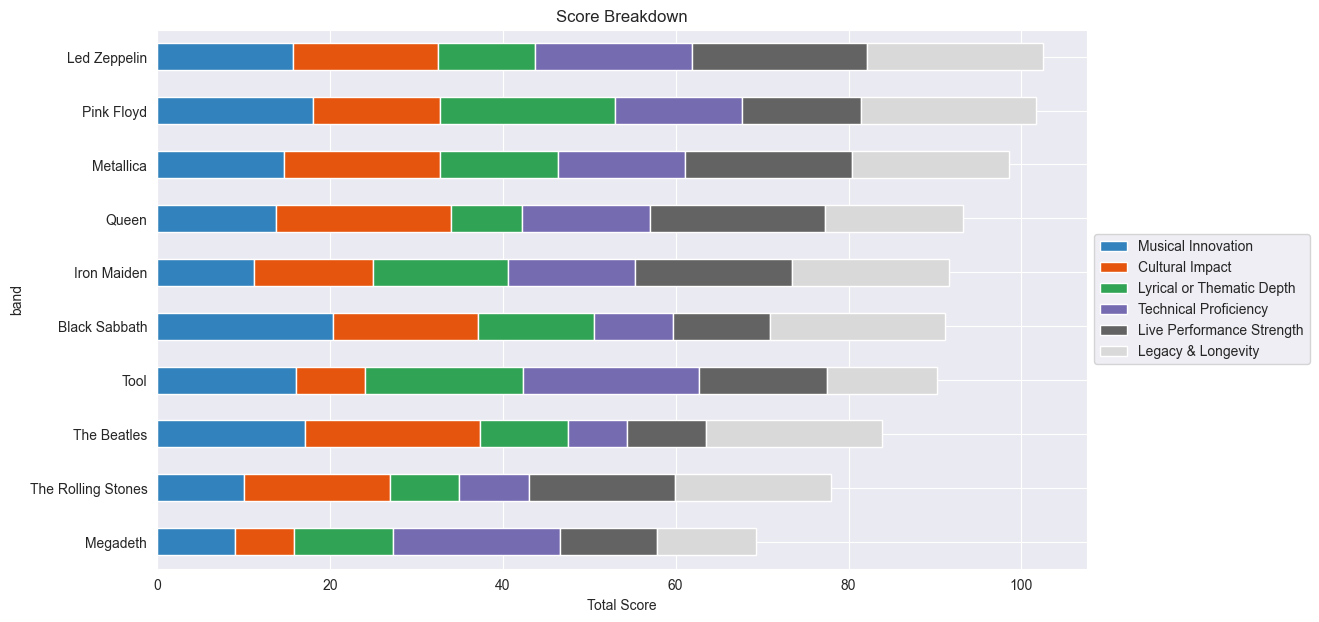

In [8]:
final_scores.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='tab20c')
plt.title("Score Breakdown")
plt.xlabel("Total Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Visualization: Radar Chart

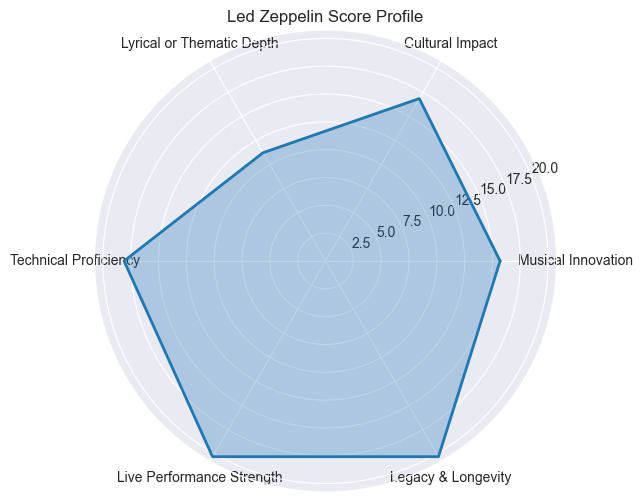

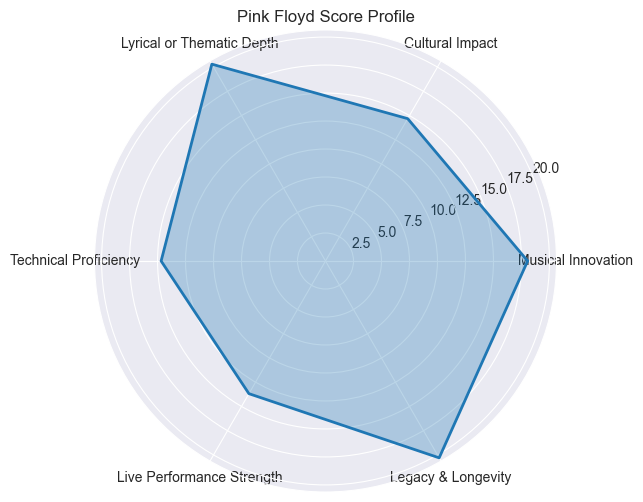

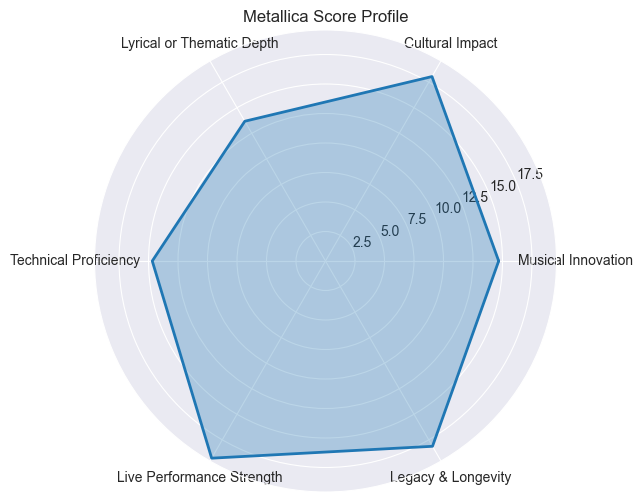

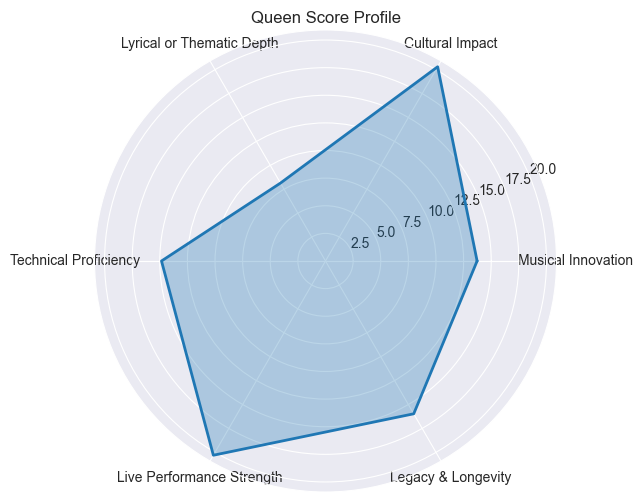

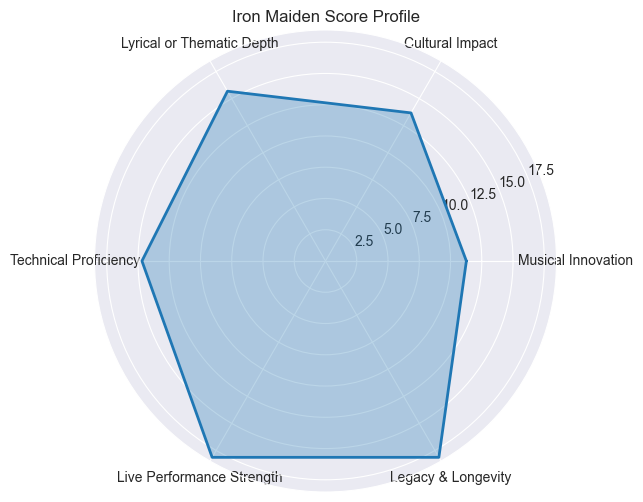

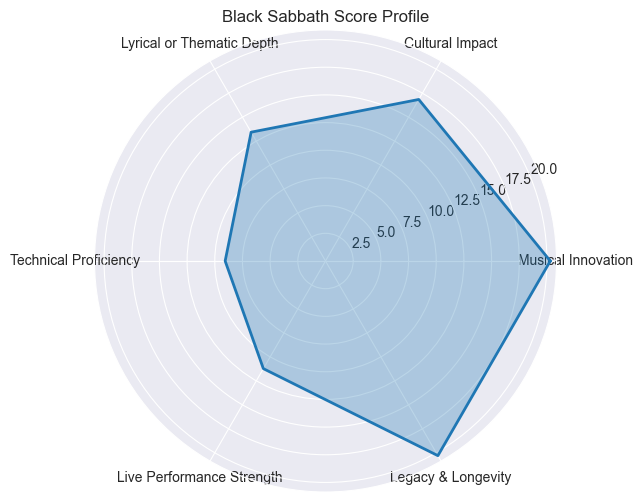

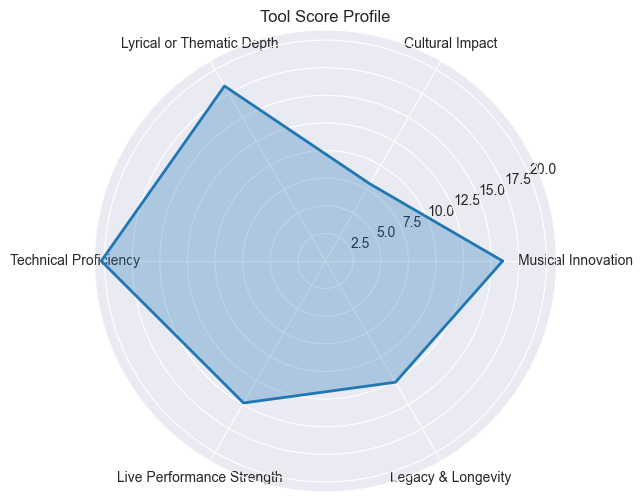

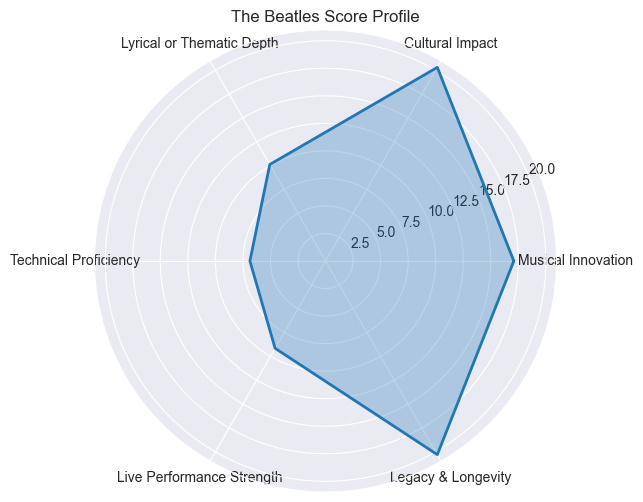

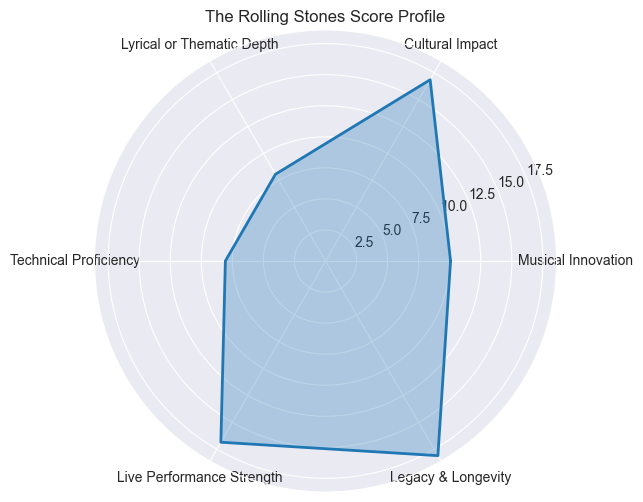

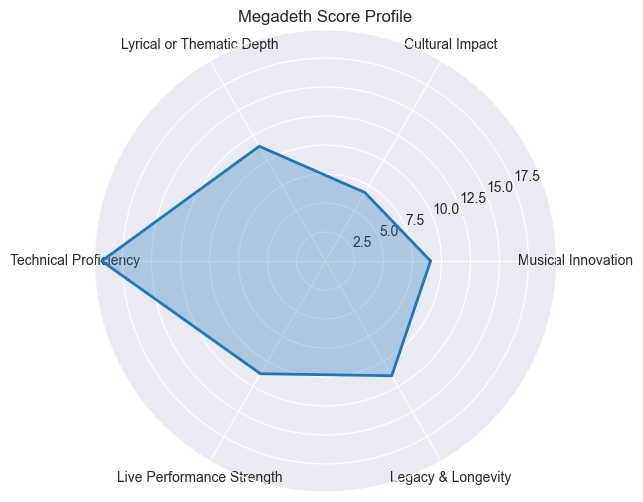

In [9]:
items = final_scores.mean(axis=1).sort_values(ascending=False).index

for item in items:
    values = final_scores.loc[item, criteria_keys].values.flatten().tolist()
    values += values[:1]

    angles = np.linspace(0, 2 * np.pi, len(criteria_keys), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, label=item)
    ax.fill(angles, values, alpha=0.3)
    ax.set_thetagrids(np.degrees(angles[:-1]), criteria_keys)
    ax.set_title(f"{item} Score Profile")
    plt.show()

In [ ]:
import pandas as pd
import seaborn as sns

# Assemble the heatmap DataFrame
rank_matrix = []
for agent in PERSONAS:
    ranking = result[f"{agent}_ranking"]
    rank_row = {band: i + 1 for i, band in enumerate(ranking)}
    rank_matrix.append(rank_row)

rank_df = pd.DataFrame(rank_matrix, index=PERSONAS.keys())
plt.figure(figsize=(14, 6))
sns.heatmap(rank_df, cmap="coolwarm", annot=True, fmt="d", cbar_kws={"label": "Rank (lower is better)"})
plt.title("Band Rankings by Persona")
plt.xlabel("Band")
plt.ylabel("Persona")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Compute standard deviation of rankings across agents
band_ranks = {band: [] for band in ITEMS}
for agent in PERSONAS:
    for i, band in enumerate(result[f"{agent}_ranking"]):
        band_ranks[band].append(i + 1)

stats = {
    band: {
        "mean_rank": np.mean(ranks),
        "std_dev": np.std(ranks),
        "min_rank": min(ranks),
        "max_rank": max(ranks)
    }
    for band, ranks in band_ranks.items()
}

rank_stats_df = pd.DataFrame(stats).T.sort_values("std_dev", ascending=False)
rank_stats_df


In [ ]:
df = result["summary_df"]
df.head()


In [ ]:
for col in df.columns:
    print(f"\n🔹 Top 5 bands by {col.upper()}:")
    display(df.sort_values(col, ascending=False).head(5))


In [ ]:
df["std_dev"] = df.std(axis=1)
df["mean"] = df.mean(axis=1)
df_consistency = df.sort_values("std_dev")
df_consistency[["mean", "std_dev"]]


In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df[categories].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Evaluation Criteria")
plt.show()


In [ ]:
top_bands = df_sorted.head(10)
top_bands.iloc[:, :6].plot(kind='barh', stacked=True, figsize=(12, 7), colormap='tab20c')
plt.title("🎼 Top 10 Bands by Score Breakdown")
plt.xlabel("Total Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
